# 1. Libraries

In [38]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib
# !pip install python --upgrade
# !pip install keras tensorflow --upgrade
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 4.8 MB/s eta 0:00:00


In [55]:
import os
import zipfile
import shutil
import numpy as np
import cv2
import imghdr
import tensorflow as tf

import plotly
import plotly.graph_objects as go
from prettytable import PrettyTable
from keras import models,layers , optimizers
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Flatten
from matplotlib import pyplot as plt


# GPU CHeck for Colab

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **COLAB kaggle data file SETUP**

In [10]:
import requests

# URL of the raw file on GitHub
github_url = "https://raw.githubusercontent.com/dynci22/Thesis/main/kaggle.json"

#HTTP GET request to download the file
response = requests.get(github_url)

#if the request was successful (status code 200)
if response.status_code == 200:
    # Save the content to a json file
    with open("kaggle.json", "wb") as file:
        file.write(response.content)
else:
    print("Failed to download the file.")


In [11]:
# Step 1: Set up Kaggle API credentials
kaggle_credentials_path = "/content/kaggle.json"
if os.path.exists(kaggle_credentials_path):
    kaggle_directory = os.path.expanduser("~/.kaggle")
    os.makedirs(kaggle_directory, exist_ok=True)
    kaggle_config_path = os.path.join(kaggle_directory, "kaggle.json")
    shutil.copy(kaggle_credentials_path, kaggle_config_path)
    os.chmod(kaggle_config_path, 0o600)
    # Step 2: Download dataset
    dataset_name = "gpiosenka/butterfly-images40-species"
    download_command = f"kaggle datasets download -d {dataset_name}"
    os.system(download_command)
    # Step 3: Unzip dataset and remove ZIP files
    zip_files = [file for file in os.listdir() if file.endswith(".zip")]
    for zip_file in zip_files:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall()
        os.remove(zip_file)
    print("Dataset download and setup completed.")
else:
    print("Kaggle API credentials (kaggle.json) not found.")



Dataset download and setup completed.


# 2. Exploratory Data Analysis

In [12]:
base_dir = '/content'
dir_names = ['train', 'test', 'valid']
dir_list = [os.path.join(base_dir, dir_name) for dir_name in dir_names]

In [13]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [14]:
for dir in dir_list:
  for image_class in os.listdir(dir):
      for image in os.listdir(os.path.join(dir, image_class)):
          image_path = os.path.join(dir, image_class, image)
          try:
              img = cv2.imread(image_path)
              tip = imghdr.what(image_path)
              if tip not in image_exts:
                  print('Image not in ext list {}'.format(image_path))
                  os.remove(image_path)
          except Exception as e:
              print('Issue with image {}'.format(image_path))

In [15]:
# Initialized counters for total folder and image counts
folder_count = 0
image_count = 0

# Created a table to display the results
table = PrettyTable(["Folder Name", "Subfolders", "Images"])

# Function to count image files in a directory
def count_images_in_dir(directory):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  # Add more extensions as needed
    count = 0
    for root, _, files in os.walk(directory):
        count += sum(1 for filename in files if any(filename.lower().endswith(ext) for ext in image_extensions))
    return count

# Loop through the specified subdirectories
for dir_path in dir_list:
    # Initialized counters for the current subdirectory
    subfolder_count = 0
    current_image_count = count_images_in_dir(dir_path)

    # Traversed the directory structure within the current subdirectory
    for root, dirs, _ in os.walk(dir_path):
        folder_count += 1  # Incremented the total folder count
        subfolder_count += len(dirs)

    # Added the data to the table for the current subdirectory
    table.add_row([dir_path, subfolder_count, current_image_count])

# Printed the table displaying counts for each specified subdirectory
print(table)


+----------------+------------+--------+
|  Folder Name   | Subfolders | Images |
+----------------+------------+--------+
| /content/train |    100     | 12594  |
| /content/test  |    100     |  500   |
| /content/valid |    100     |  500   |
+----------------+------------+--------+


# 3. Load Data

In [16]:
# Created TensorFlow datasets
data_train = tf.keras.utils.image_dataset_from_directory(
    dir_list[0],               # Loaded 'train' directory
    labels='inferred',
    label_mode='categorical',  # Used 'categorical' for multi-class classification
    batch_size=32,             # Set the desired batch size
    image_size=(224, 224),     # Set the desired image size
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None
)

data_test = tf.keras.utils.image_dataset_from_directory(
    dir_list[1],               # Loaded 'test' directory
    labels='inferred',
    label_mode='categorical',  # Used 'categorical' for multi-class classification
    batch_size=32,             # Set the desired batch size
    image_size=(224, 224),     # Set the desired image size
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None
)

data_valid = tf.keras.utils.image_dataset_from_directory(
    dir_list[2],               # Loaded 'valid' directory
    labels='inferred',
    label_mode='categorical',  # Used 'categorical' for multi-class classification
    batch_size=32,             # Set the desired batch size
    image_size=(224, 224),     # Set the desired image size
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None
)


Found 12594 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


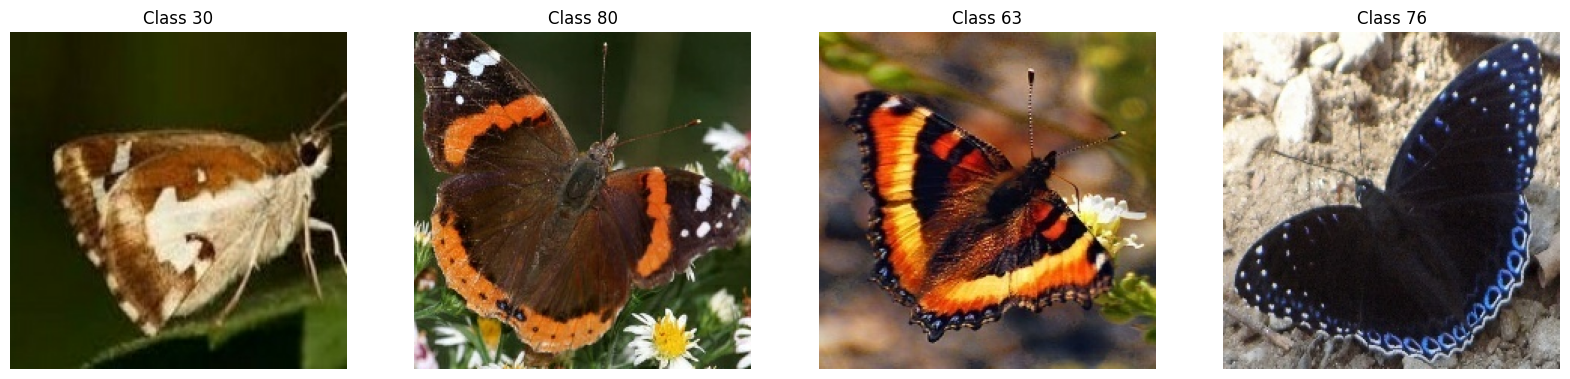

In [56]:
# Created subplots with 4 columns and a large figure size
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# Looped through the first 4 batches in the data_train dataset
for idx, (images, labels) in enumerate(data_train.take(4)):
    # Displayed individual images from the batch
    ax[idx].imshow(images[0].numpy().astype(int))  # Assuming batch size is 32, choose the first image

    # Set the title of the subplot to the corresponding label
    label_index = tf.argmax(labels[0])  # Use the first label in the batch
    ax[idx].set_title(f"Class {label_index.numpy()}")

    # Turned off the axis labels and ticks for better visualization
    ax[idx].axis('off')

# Showed the subplots
plt.show()


# 4. Scale Data

In [57]:
def print_dataset_details(dataset, name):
    # Print batch size and other details for the dataset
    print(f"{name} Dataset:")
    print(f"Batch Size: {dataset._batch_size.numpy()}")
    print(f"Number of Batches: {len(dataset)}")

    # Count the unique labels to determine the number of classes in the dataset
    unique_labels = set()
    for _, labels in dataset:
        unique_labels.update(tf.argmax(labels, axis=1).numpy())

    num_classes = len(unique_labels)
    print(f"Number of Classes: {num_classes}")
    print(f"Image Shape: {dataset.element_spec[0].shape}")
    print("\n")

# Call the function for each dataset
print_dataset_details(data_train, "Training")
print_dataset_details(data_test, "Testing")
print_dataset_details(data_valid, "Validation")


Training Dataset:
Batch Size: 32
Number of Batches: 394
Number of Classes: 100
Image Shape: (None, 224, 224, 3)


Testing Dataset:
Batch Size: 32
Number of Batches: 16
Number of Classes: 100
Image Shape: (None, 224, 224, 3)


Validation Dataset:
Batch Size: 32
Number of Batches: 16
Number of Classes: 100
Image Shape: (None, 224, 224, 3)




In [58]:
def scale_dataset(dataset):
    """
    Scales the image data in a dataset to the range [0, 1].

    Args:
        dataset: A TensorFlow dataset containing image-label pairs.

    Returns:
        scaled_dataset: A scaled TensorFlow dataset.
    """
    scaled_dataset = dataset.map(lambda image, label: (image / 255.0, label))
    return scaled_dataset

In [59]:
scaled_data_train = scale_dataset(data_train)
scaled_data_test = scale_dataset(data_test)
scaled_data_valid = scale_dataset(data_valid)


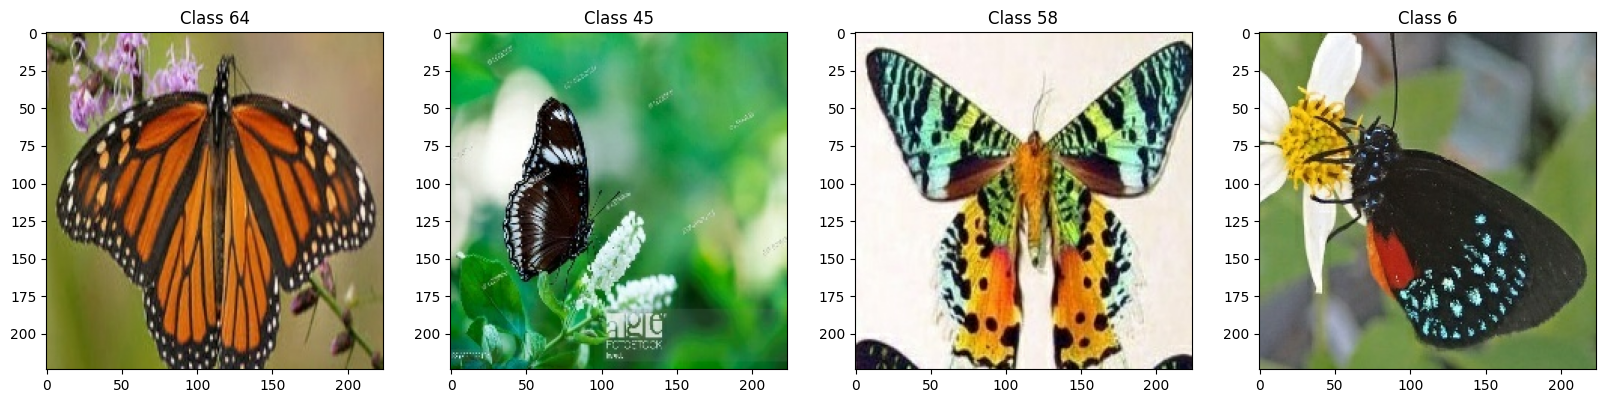

In [60]:
# Created subplots with 4 columns and a large figure size
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# Looped through the first 4 batches in the data_train dataset
for idx, (images, labels) in enumerate(scaled_data_train.take(4)):
    # Displayed the images without scaling
    ax[idx].imshow(images[0].numpy())

    # Set the title of the subplot to the corresponding label
    label_index = tf.argmax(labels[0])  # Used the first label in the batch
    ax[idx].set_title(f"Class {label_index.numpy()}")

    # Turned off the axis labels and ticks for better visualization
    ax[idx].axis('on')

# Showed the subplots
plt.show()


# 6. Build Deep Learning Model

In [77]:
model = models.Sequential()

# Convolutional layers with batch normalization and dropout
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Flatten layer
model.add(layers.Flatten())

# Dense layers with dropout
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='softmax'))  # 100 classes

# model with a learning rate scheduler
initial_learning_rate = 0.001
adam_optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9)
model.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Print model summary
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_20 (Ba  (None, 222, 222, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_21 (Ba  (None, 109, 109, 64)     

In [79]:
# Print input shape
print("Input Shape:", model.input_shape)

# Print output shape after each layer
for layer in model.layers:
    print("Layer Name:", layer.name)
    print("Output Shape:", layer.output_shape)

Input Shape: (None, 224, 224, 3)
Layer Name: conv2d_18
Output Shape: (None, 222, 222, 32)
Layer Name: batch_normalization_20
Output Shape: (None, 222, 222, 32)
Layer Name: max_pooling2d_18
Output Shape: (None, 111, 111, 32)
Layer Name: dropout_20
Output Shape: (None, 111, 111, 32)
Layer Name: conv2d_19
Output Shape: (None, 109, 109, 64)
Layer Name: batch_normalization_21
Output Shape: (None, 109, 109, 64)
Layer Name: max_pooling2d_19
Output Shape: (None, 54, 54, 64)
Layer Name: dropout_21
Output Shape: (None, 54, 54, 64)
Layer Name: conv2d_20
Output Shape: (None, 52, 52, 128)
Layer Name: batch_normalization_22
Output Shape: (None, 52, 52, 128)
Layer Name: max_pooling2d_20
Output Shape: (None, 26, 26, 128)
Layer Name: dropout_22
Output Shape: (None, 26, 26, 128)
Layer Name: flatten_6
Output Shape: (None, 86528)
Layer Name: dense_12
Output Shape: (None, 256)
Layer Name: batch_normalization_23
Output Shape: (None, 256)
Layer Name: dropout_23
Output Shape: (None, 256)
Layer Name: dense_13


# 7. Train

In [80]:
# Use the ! shell command to run shell commands
!mkdir /content/logs

print("Directory created.")

logdir='logs'

mkdir: cannot create directory ‘/content/logs’: File exists
Directory created.


In [81]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [90]:
history = model.fit(data_train,
                    epochs=5,
                    validation_data=data_valid)


Epoch 1/5
394/394 [==============================] - 54s 136ms/step - loss: 0.0843 - accuracy: 0.9786 - val_loss: 1.0830 - val_accuracy: 0.7200
Epoch 2/5
394/394 [==============================] - 53s 135ms/step - loss: 0.0823 - accuracy: 0.9778 - val_loss: 1.1534 - val_accuracy: 0.6980
Epoch 3/5
394/394 [==============================] - 54s 135ms/step - loss: 0.0761 - accuracy: 0.9775 - val_loss: 1.2892 - val_accuracy: 0.7140
Epoch 4/5
394/394 [==============================] - 54s 136ms/step - loss: 0.0715 - accuracy: 0.9796 - val_loss: 1.4421 - val_accuracy: 0.6800
Epoch 5/5
394/394 [==============================] - 54s 135ms/step - loss: 0.0638 - accuracy: 0.9833 - val_loss: 1.1778 - val_accuracy: 0.7320


# 8. Plot Performance

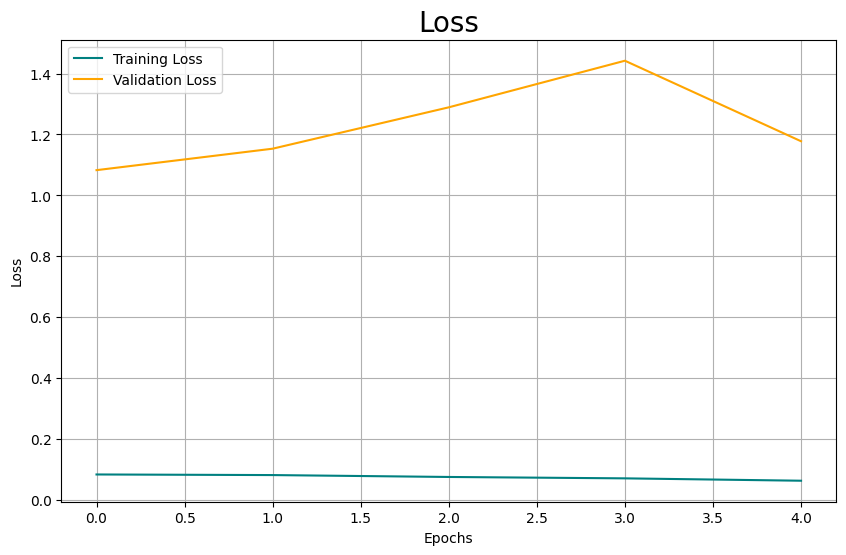

In [91]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], color='teal', label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


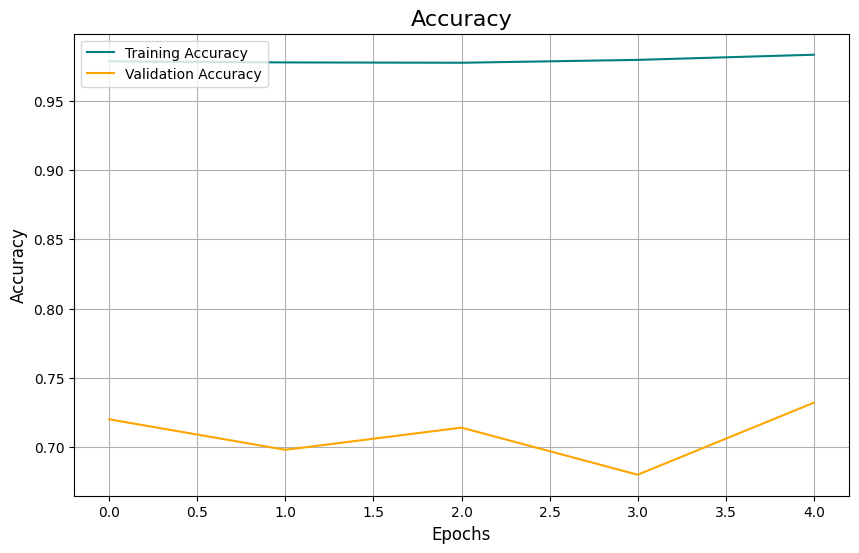

In [92]:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], color='teal', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    plt.title('Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()



# 9. Evaluate

In [85]:
def get_class_names(data_dir):
    return sorted(os.listdir(data_dir))

def evaluate_test(model, modelName, test, test_dir):
    print(f"Model: {modelName} / Test: {test_dir}")
    print()

    # Get class names from subfolder names
    class_names = get_class_names(test_dir)

    # Initialize lists to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Loop through the test data to get true and predicted labels
    for batch, labels in test:
        predicted_data = model.predict(batch)
        yhat_classes = np.argmax(predicted_data, axis=1)

        true_labels.extend(np.argmax(labels, axis=1))
        predicted_labels.extend(yhat_classes)

    # Convert the lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate precision, recall, and accuracy
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Print precision, recall, and accuracy
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Calculate and print confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    fig = go.Figure(data=[go.Heatmap(z=conf_matrix, x=class_names, y=class_names)])
    fig.update_layout(
        title=f"Confusion Matrix {modelName} applied on {test_dir}",
        xaxis_title="Predicted",
        yaxis_title="True",
        autosize=False,
        width=600,
        height=600
    )
    fig.show()

    # Print classification report with precision, recall, f1-score, and support
    class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print()
    print(f"Classification Report for {modelName} applied on {test_dir}:")
    print(class_report)

    # Print summary
    print()
    loss, accuracy = model.evaluate(test)
    print(f"Test Loss for {modelName} applied on {test_dir}: {loss:.4f}")
    print(f"Test Accuracy for {modelName} applied on {test_dir}: {accuracy * 100:.2f}%")
    print("-----------------------------------------------------------------------")
    print()


In [86]:
# Evaluate on the 'train' dataset
# evaluate_test(model, "data_train", data_train, dir_list[0])

# # Evaluate on the 'test' dataset
evaluate_test(model, "data_test", data_test, dir_list[1])

# # Evaluate on the 'valid' dataset
# evaluate_test(model, "data_valid", data_valid, dir_list[2])


Model: data_test / Test: /content/test

1/1 [==============================] - 0s 293ms/step
Precision: 78.86%
Recall: 73.00%
Accuracy: 73.00%



Classification Report for data_test applied on /content/test:
                           precision    recall  f1-score   support

                   ADONIS       0.50      1.00      0.67         5
AFRICAN GIANT SWALLOWTAIL       0.83      1.00      0.91         5
           AMERICAN SNOOT       0.33      0.40      0.36         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      0.40      0.57         5
     ARCIGERA FLOWER MOTH       1.00      0.60      0.75         5
                    ATALA       0.57      0.80      0.67         5
               ATLAS MOTH       1.00      0.80      0.89         5
 BANDED ORANGE HELICONIAN       1.00      0.80      0.89         5
           BANDED PEACOCK       0.71      1.00      0.83         5
        BANDED TIGER MOTH       0.62      1.00      0.77         5
            BECKERS WHITE       0.67      0.40      0.50         5
  BIRD CHERRY ERMINE MOTH       1.00      0.60      0.75         